# ICV

- Area : Applied Social Sciences
- Start : jan-1970
- Finish : jun-1980
- Stationary : No
- m : 126

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error

sys.path.append("../utils/")
from data import load_dataset
from plot import plot, plot_stl, acf, plot_dist
from forecasting import Naive, SeasonalNaive, TimeSeriesForecaster
from metrics import pocid, multi_criteria

## Data

In [2]:
data = load_dataset(10)
period = 12
detrend = True

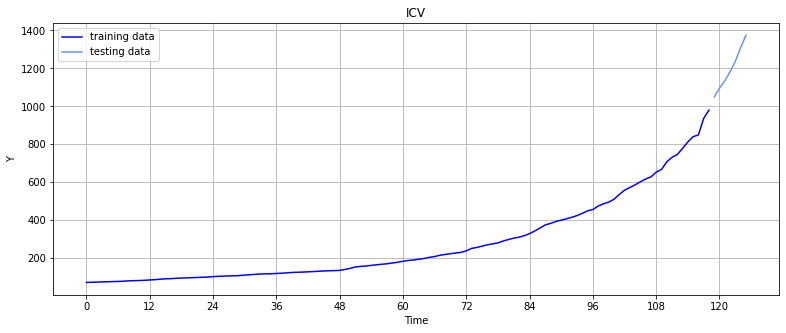

In [3]:
plot(data, 'ICV')

## STL decomposition

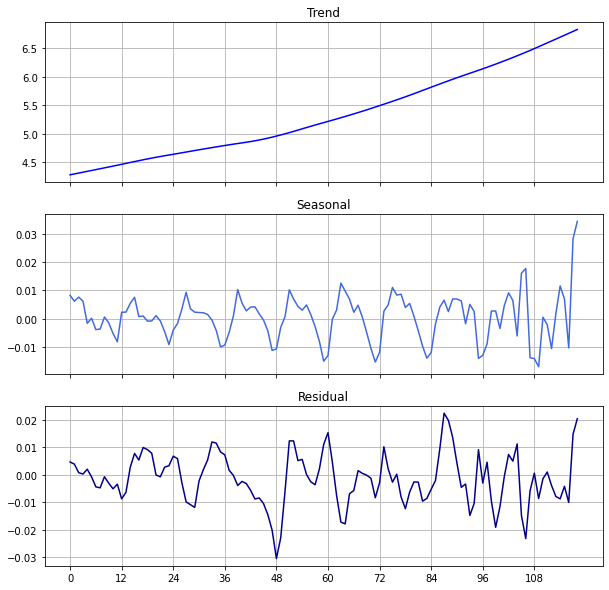

In [4]:
res = plot_stl(np.log1p(data[0]))

## Residual Diagnostics

In [5]:
acorr_ljungbox(res.resid, period=period, return_df=True)

,lb_stat,lb_pvalue
1,50.892334,9.757395e-13
2,56.519884,5.331669e-13
3,56.856613,2.757530e-12
4,63.856391,4.480524e-13
5,69.547311,1.272999e-13
6,69.925157,4.235966e-13
7,70.557381,1.139819e-12
8,70.569774,3.784435e-12
9,72.484494,4.949694e-12
10,81.498788,2.550902e-13


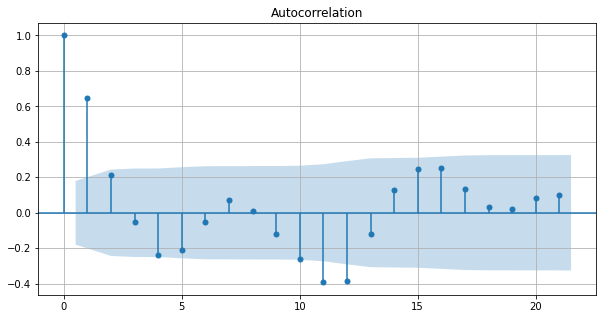

In [6]:
acf(res.resid)

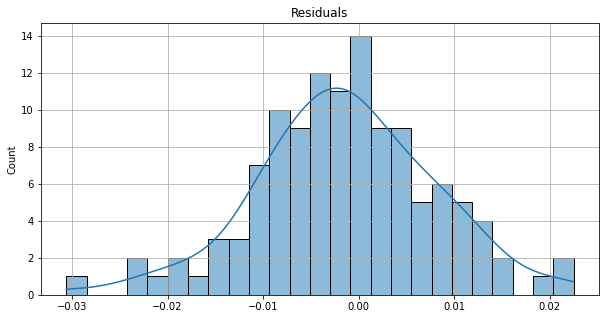

In [7]:
plot_dist(res.resid)

## Fitting and Forecasting

In [8]:
# Naive forecaster
naive = Naive()
naive.fit(data[0])
y_naive = naive.predict(len(data[1]))

# Seasonal Naive forecaster
snaive = SeasonalNaive(period=period)
snaive.fit(data[0])
y_snaive = snaive.predict(len(data[1]))

# Bayesian Ridge Regression
br = TimeSeriesForecaster(BayesianRidge(), window_length=period, detrend=detrend)
br.fit(data[0])
y_br = br.predict(len(data[1]))

# Hybrid Bayesian Ridge Regression
sbr = TimeSeriesForecaster(BayesianRidge(), window_length=period, detrend=detrend, period=period)
sbr.fit(data[0])
y_sbr = sbr.predict(len(data[1]))

# Kernel Ridge Regression
kr = TimeSeriesForecaster(KernelRidge(kernel="rbf"), window_length=period, detrend=detrend)
kr.fit(data[0])
y_kr = kr.predict(len(data[1]))

# Hybrid Kernel Ridge Regression
skr = TimeSeriesForecaster(KernelRidge(kernel="rbf"), window_length=period, detrend=detrend, period=period)
skr.fit(data[0])
y_skr = skr.predict(len(data[1]))

# Support Vector Machine
svr = TimeSeriesForecaster(LinearSVR(dual=False, loss="squared_epsilon_insensitive"), window_length=period, detrend=detrend)
svr.fit(data[0])
y_svr = svr.predict(len(data[1]))

# Hybrid Support Vector Machine
ssvr = TimeSeriesForecaster(
    LinearSVR(dual=False, loss="squared_epsilon_insensitive"), window_length=period, detrend=detrend, period=period)
ssvr.fit(data[0])
y_ssvr = ssvr.predict(len(data[1]))

# Kernel Support Vector Machine
ksvr = TimeSeriesForecaster(SVR(), window_length=period, detrend=detrend)
ksvr.fit(data[0])
y_ksvr = ksvr.predict(len(data[1]))

# Hybrid Kernel Support Vector Machine
sksvr = TimeSeriesForecaster(SVR(), window_length=period, detrend=detrend, period=period)
sksvr.fit(data[0])
y_sksvr = sksvr.predict(len(data[1]))

## Model Evaluation

In [9]:
maes = np.array([
    mean_absolute_error(data[1], y_br), mean_absolute_error(data[1], y_sbr), mean_absolute_error(data[1], y_kr),
    mean_absolute_error(data[1], y_skr), mean_absolute_error(data[1], y_svr), mean_absolute_error(data[1], y_ssvr),
    mean_absolute_error(data[1], y_ksvr), mean_absolute_error(data[1], y_sksvr)
])

pocids = np.array([
    pocid(data[1], y_br), pocid(data[1], y_sbr), pocid(data[1], y_kr), pocid(data[1], y_skr),
    pocid(data[1], y_svr), pocid(data[1], y_ssvr), pocid(data[1], y_ksvr), pocid(data[1], y_sksvr)
])

tu_naive = maes / mean_absolute_error(data[1], y_naive)
tu_snaive = maes / mean_absolute_error(data[1], y_snaive)

error_table = {
    "model" : [
        "Bayesian Ridge", "Seasonal Bayesian Ridge", "Kernel Ridge", "Seasonal Kernel Ridge",
        "SVR", "Seasonal SVR", "Kernel SVR", "Seasonal Kernel SVR"],
    "MAE" : maes,
    "TU-naive" : tu_naive,
    "TU-snaive" : tu_snaive,
    "POCID" : pocids
}

df = pd.DataFrame(error_table)
df = df.set_index("model")
df["MC"] = [multi_criteria(df.iloc[i,1:]) for i in range(len(df))]
df

,MAE,TU-naive,TU-snaive,POCID,MC
model,,,,,
Bayesian Ridge,55.721863,0.256614,0.112407,0.857143,0.035318
Seasonal Bayesian Ridge,103.954272,0.478737,0.209706,0.857143,0.086058
Kernel Ridge,1093.106286,5.034042,2.205114,0.000000,7.941362
Seasonal Kernel Ridge,1092.731093,5.032314,2.204357,0.000000,7.936987
SVR,181.020580,0.833647,0.365171,0.857143,0.205977
Seasonal SVR,195.256823,0.899209,0.393890,0.857143,0.233358
Kernel SVR,389.065646,1.791750,0.784859,0.000000,1.724637
Seasonal Kernel SVR,413.794174,1.905631,0.834743,0.142857,1.705899


In [10]:
print("Naive MAE: ", mean_absolute_error(data[1], y_naive))
print("SNaive MAE: ", mean_absolute_error(data[1], y_snaive))

Naive MAE:  217.14285714285714
SNaive MAE:  495.7142857142857
